## Goals of notebook
1. Create nice visualizations of the LE data
2. Create figure template of a polar projection for:
    a. Unperturbed
    b. Perturbed
    c. Difference

how to accomplish that.... know what you want to plot, make a dataset of that data, import it and plot:
ie the data wrangling should be done elsewhere

Devi's Paper:  historical period (1960-1989) // “future” (2070-2099)


In [1]:
# set up modules
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import intake
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [64]:
pwd = os.getcwd()
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

## Spatial Variance

In [2]:
ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean.zarr')

In [3]:
#get difference between epochs
with xr.set_options(keep_attrs=True):  
    ds_djf_epoch_diff = ds_djf_epoch.diff('epoch').squeeze('epoch')
#ds_djf_epoch_diff

In [4]:
ds_djf_epoch

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 3, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1920-1950' '2070-2100'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

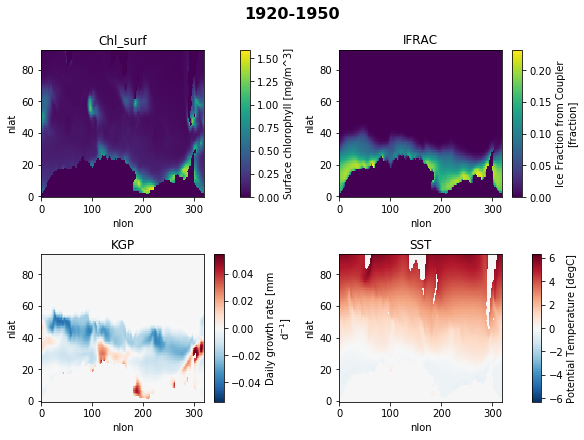

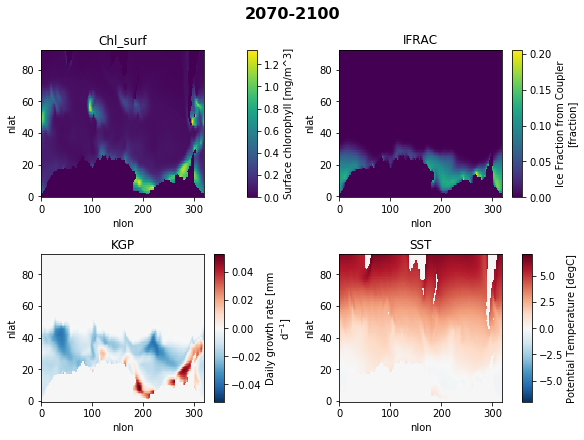

In [5]:
for epoch in ds_djf_epoch.epoch.values:

    nvar = len(ds_djf_epoch.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)
    for i, v in enumerate(ds_djf_epoch.data_vars): #for index, item in enmuerate(choices):
        plt.axes(ax.ravel()[i]) #the plot axes are a list of the index, unravelled

        with xr.set_options(keep_attrs=True):             
            var = ds_djf_epoch[v].sel(epoch=epoch).mean('member_id') # for the data variable in the ds, select the data by epoch, then take it's mean, using the member_id 
        if 'length' in var.dims: 
            var = var.sel(length=40.)            
        var.plot()        
        plt.title(v);
    plt.suptitle(epoch, fontsize=16, fontweight='bold')

In [8]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import esmlab
from glob import glob
import cartopy
import cartopy.crs as ccrs
import esmlab
import warnings
warnings.filterwarnings('ignore')
import ncar_jobqueue
from dask.distributed import Client
import cmocean

In [65]:
#for saving figures:
pwd = os.getcwd()
pwd
os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/figures'

In [80]:
## Create Datafields to plot
kgp_mean = ds_djf_epoch['KGP'].mean('member_id')
sst_mean = ds_djf_epoch['SST'].mean('member_id')
chl_mean = ds_djf_epoch['Chl_surf'].mean('member_id')
ice_mean = ds_djf_epoch['IFRAC'].mean('member_id')

kgp_early = kgp_mean.sel(length='40').sel(epoch='1920-1950')
kgp_late = kgp_mean.sel(length='40').sel(epoch='2070-2100')
sst_early = sst_mean.sel(epoch='1920-1950')
sst_late = sst_mean.sel(epoch='2070-2100')
chl_early = chl_mean.sel(epoch='1920-1950')
chl_late = chl_mean.sel(epoch='2070-2100')
ice_early = ice_mean.sel(epoch='1920-1950')
ice_late = ice_mean.sel(epoch='2070-2100')


In [79]:
# Lat Lon Checks
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values

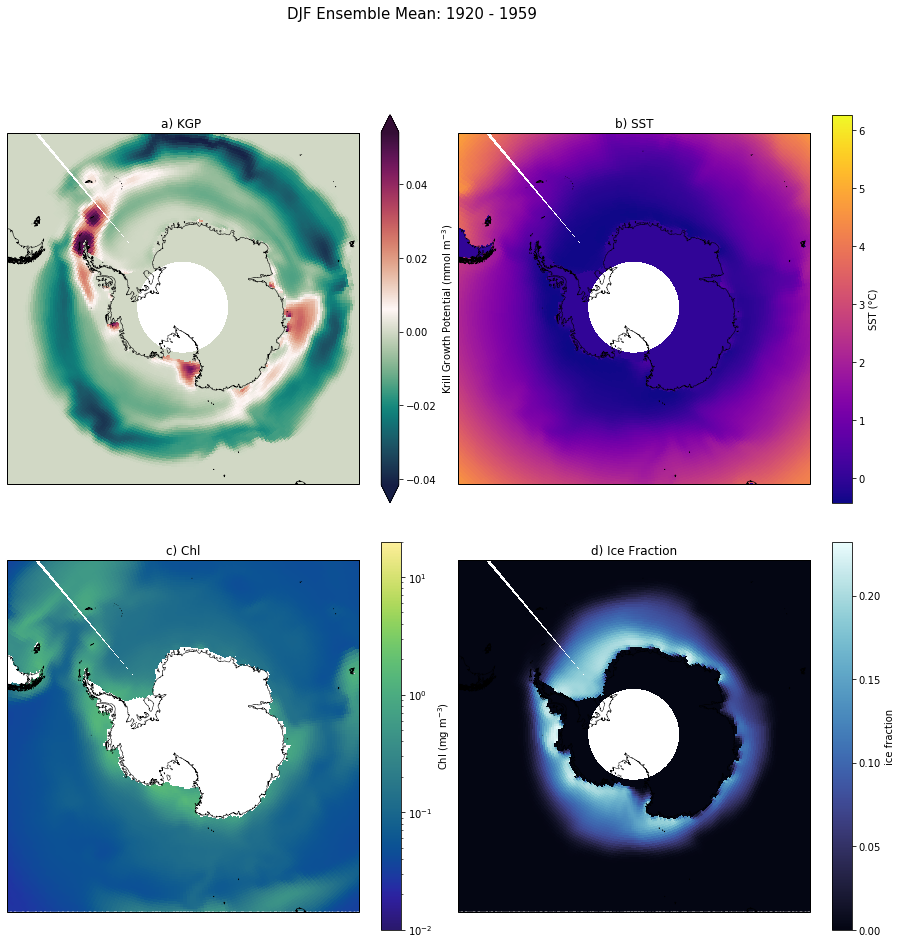

In [100]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: 1920 - 1959', fontsize=15)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')

pc=ax.pcolormesh(lon, lat, kgp_early, cmap='cmo.curl', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Krill Growth Potential (mmol m$^{-3}$)')


#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_early, cmap='plasma', transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.01, vmax=20.)

pc=ax.pcolormesh(lon, lat, chl_early, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_early, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')

fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

#fig.savefig('1920-1959', bbox_inches='tight') #,format='pdf');


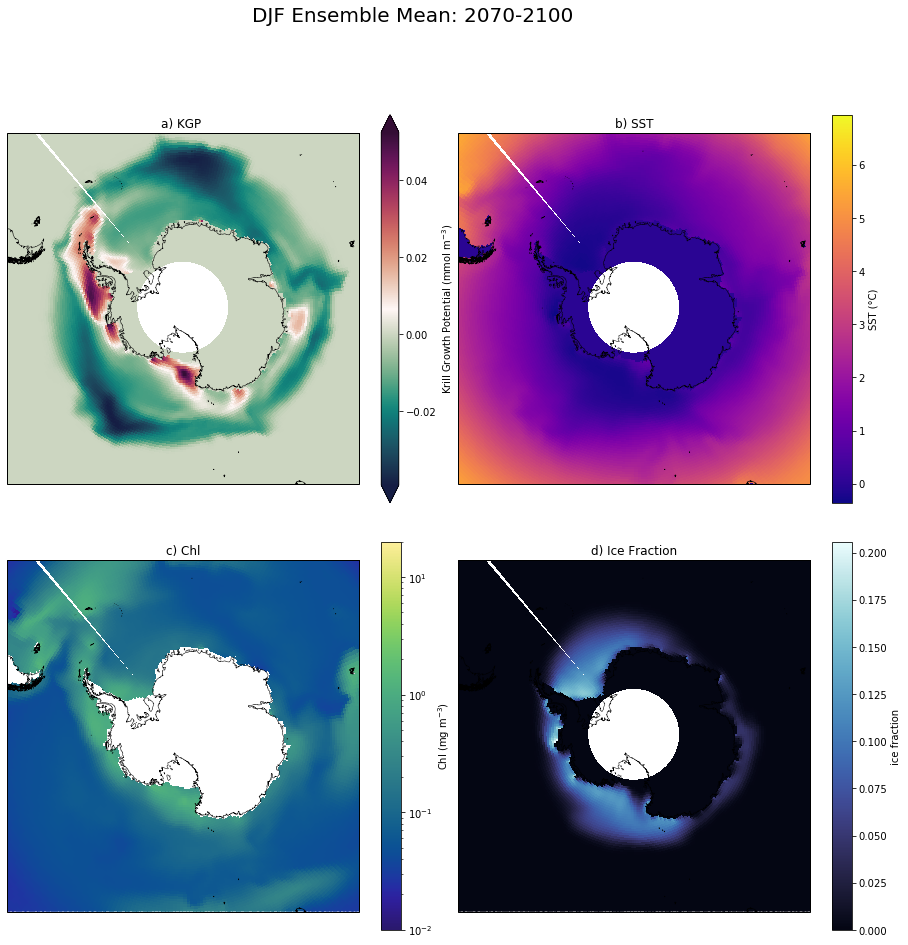

In [99]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: 2070-2100', fontsize=15)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')

pc=ax.pcolormesh(lon, lat, kgp_late, cmap='cmo.curl', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Krill Growth Potential (mmol m$^{-3}$)')


#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_late, cmap='plasma', transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.01, vmax=20.)

pc=ax.pcolormesh(lon, lat, chl_late, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_late, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')

fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

#fig.savefig('2070-2100', bbox_inches='tight') #,format='pdf');


___
## Testing Other plot bits

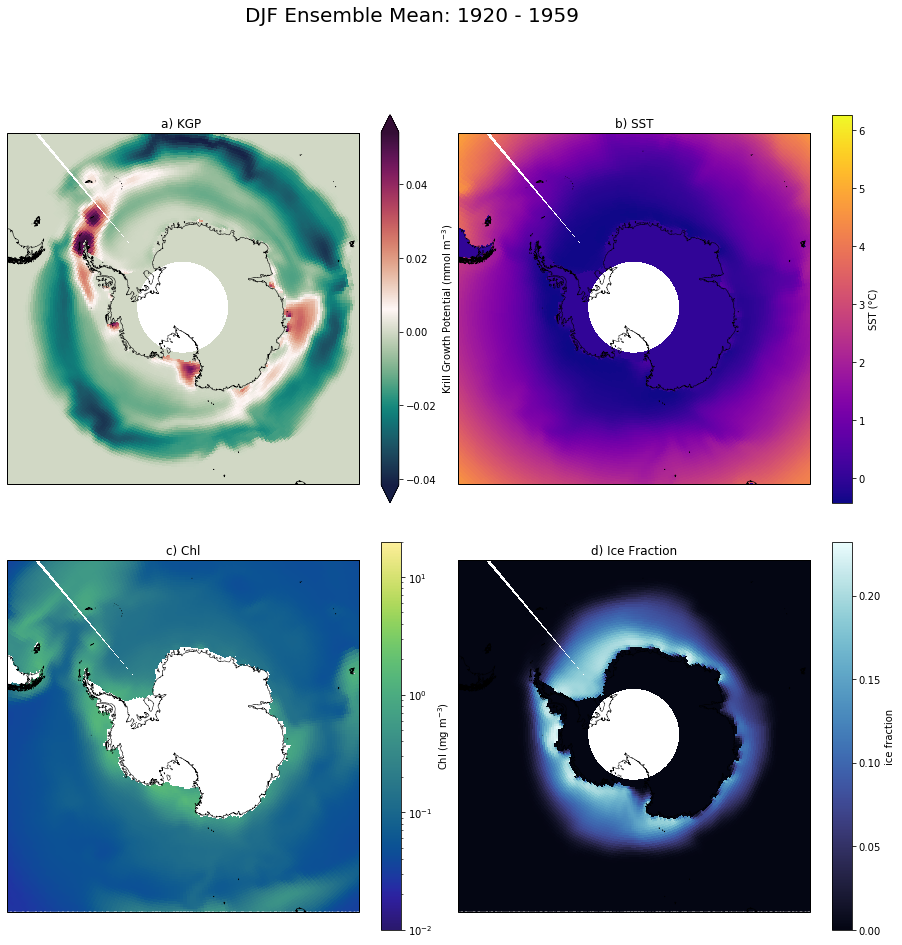

In [97]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(15,15))
fig.suptitle('DJF Ensemble Mean: 1920 - 1959', fontsize=20)

#---------- KGP
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) KGP ')

pc=ax.pcolormesh(lon, lat, kgp_early, cmap='cmo.curl', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Krill Growth Potential (mmol m$^{-3}$)')


#----------SST
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) SST')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, sst_early, cmap='plasma', transform=ccrs.PlateCarree())
cbar2 = fig.colorbar(pc, ax=ax,label='SST (°C)')

#----------Chl
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) Chl')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)

norm = colors.LogNorm(vmin=0.01, vmax=20.)

pc=ax.pcolormesh(lon, lat, chl_early, cmap=cmocean.cm.haline,
                 norm=norm,
                 transform=ccrs.PlateCarree())
cbar3 = fig.colorbar(pc, ax=ax,label='Chl (mg m$^{-3}$)')

#----------IFRAC
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) Ice Fraction')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, ice_early, cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
cbar4 = fig.colorbar(pc, ax=ax,label='ice fraction')

fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)

#fig.savefig('1920-1959_50lat.pdf', bbox_inches='tight') #,format='pdf');


___
## Temporal Variance

In [ ]:
#load data
ds_djf = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries.zarr')